In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/10.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/7.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/8.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/9.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/1.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/14.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/12.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/2.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/4.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation/6.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Test/3.txt
/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Test/10.txt
/kaggle/inpu

In [2]:
# ================================================================
# 1)  LIBS & SETUP
# ================================================================
import os
import gc
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.interpolate import InterpolatedUnivariateSpline
from tensorflow import keras
from tensorflow.keras import layers

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)



2026-02-17 07:43:48.672311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771314229.078506      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771314229.205916      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771314230.181701      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771314230.181740      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771314230.181742      55 computation_placer.cc:177] computation placer alr

In [3]:
# ================================================================
# 2)  DATA HELPERS (Refined)
# ================================================================
def read_split(path):
    """Read all txt files: columns are t, in1, in2, out.
    Removes the first data row as requested."""
    X, Y, T = [], [], []
    mins, maxs = {'in1':[], 'in2':[], 'out':[]}, {'in1':[], 'in2':[], 'out':[]}
    
    if not os.path.exists(path):
        print(f"Path not found: {path}")
        return [], [], [], {}, {}

    for fn in sorted(os.listdir(path)):
        fp = os.path.join(path, fn)
        if not os.path.isfile(fp):
            continue
            
        # unpack=True transposes the array so we get columns
        try:
            # skiprows=1 for header. We will slice off the first data row manually below.
            data = np.loadtxt(fp, unpack=True, skiprows=1)
        except Exception as e:
            print(f"Error reading {fn}: {e}")
            continue

        # Check shapes
        if data.shape[0] < 4:
            continue

        # Data assignment (assuming format: Time, In1, In2, ..., Out)
        # Adjust indices based on your specific file structure
        t   = data[0]
        in1 = data[1]
        in2 = data[2]
        out = data[3] # Index 3 (4th column)

        # --- FIX: Check for NaNs ---
        if np.any(np.isnan(in1)) or np.any(np.isnan(in2)) or np.any(np.isnan(out)):
            continue
        
        # --- REQUIREMENT: Remove the first row of data ---
        # We slice [1:] to skip the first time step
        t   = t[1:]
        in1 = in1[1:]
        in2 = in2[1:]
        out = out[1:]

        X.append(np.stack([in1, in2], axis=-1))   # (L,2)
        Y.append(out.reshape(-1,1))               # (L,1)
        T.append(t)
        
        for k, v in zip(['in1','in2','out'], [in1,in2,out]):
            mins[k].append(v.min()); maxs[k].append(v.max())
            
    return X, Y, T, mins, maxs

def normalize(X, Y, gmins, gmaxs):
    """Scale to [0,1] using global mins/maxs."""
    imin = np.array([gmins['in1'], gmins['in2']], dtype=np.float32)
    imax = np.array([gmaxs['in1'], gmaxs['in2']], dtype=np.float32)
    omin = np.float32(gmins['out'])
    omax = np.float32(gmaxs['out'])

    Xn, Yn = [], []
    for x, y in zip(X, Y):
        x = np.asarray(x, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        # Avoid div by zero
        denom_in = imax - imin
        denom_in[denom_in == 0] = 1.0
        denom_out = omax - omin
        if denom_out == 0: denom_out = 1.0
        
        Xn.append((x - imin) / denom_in)
        Yn.append((y - omin) / denom_out)
    return Xn, Yn

def resample_split(X, Y, T, L):
    """Resample sequences to fixed length L using Splines."""
    Xr, Yr, Tr = [], [], []
    for x, y, t in zip(X, Y, T):
        xo = np.arange(len(x))
        xn = np.linspace(0, len(x)-1, L)
        
        # Resample Input (2 dim)
        rx = np.stack([InterpolatedUnivariateSpline(xo, x[:,c], k=2)(xn) for c in range(2)], axis=-1)
        # Resample Output (1 dim)
        ry = InterpolatedUnivariateSpline(xo, y[:,0], k=2)(xn).reshape(-1,1)
        # Resample Time (for plotting)
        rt = InterpolatedUnivariateSpline(xo, t, k=2)(xn)
        
        Xr.append(rx)
        Yr.append(ry)
        Tr.append(rt)
    return np.array(Xr, dtype=np.float32), np.array(Yr, dtype=np.float32), np.array(Tr, dtype=np.float32)

In [4]:
# ================================================================
# BLOCK 3: CUSTOM VANILLA GRU CELL (FIXED SERIALIZATION)
# ================================================================
# FIX: Use tf.keras.utils instead of keras.saving for compatibility
@tf.keras.utils.register_keras_serializable(package="MyLayers")
class VanillaGRUCell(layers.Layer):
    """
    Vanilla GRU Cell from scratch.
    Weights are exposed as self.kernel and self.recurrent_kernel.
    """
    def __init__(self, units, init_min=-5.0, init_max=5.0, **kwargs):
        super(VanillaGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units
        self.init_min = init_min
        self.init_max = init_max

    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        # Initialize weights between [-5, 5] as requested
        initializer = tf.random_uniform_initializer(minval=self.init_min, maxval=self.init_max)

        # Kernel: [Input -> Gates/Candidate]
        # Concatenated order: z (update), r (reset), h (candidate)
        self.kernel = self.add_weight(
            shape=(input_dim, self.units * 3),
            initializer=initializer,
            name='kernel'
        )
        
        # Recurrent Kernel: [Hidden -> Gates/Candidate]
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 3),
            initializer=initializer,
            name='recurrent_kernel'
        )

        self.bias = self.add_weight(
            shape=(self.units * 3,),
            initializer='zeros',
            name='bias'
        )
        self.built = True

    def call(self, inputs, states):
        h_tm1 = states[0]  # Previous state

        # 1. Linear Matrix Multiplications
        x_k = tf.matmul(inputs, self.kernel) 
        h_k = tf.matmul(h_tm1, self.recurrent_kernel)
        
        # 2. Split into components (z, r, h)
        x_z, x_r, x_h = tf.split(x_k, 3, axis=1)
        h_z, h_r, h_h = tf.split(h_k, 3, axis=1)
        b_z, b_r, b_h = tf.split(self.bias, 3, axis=0)

        # 3. Gates
        z = tf.nn.sigmoid(x_z + h_z + b_z) # Update gate
        r = tf.nn.sigmoid(x_r + h_r + b_r) # Reset gate
        
        # 4. Candidate State (Vanilla GRU: U_h * (r . h_prev))
        h_tilde = tf.nn.tanh(x_h + (r * h_h) + b_h)

        # 5. Update State
        h = (1 - z) * h_tm1 + z * h_tilde
        
        return h, [h]

    def get_config(self):
        config = super(VanillaGRUCell, self).get_config()
        config.update({
            "units": self.units,
            "init_min": self.init_min,
            "init_max": self.init_max
        })
        return config

In [19]:
# ================================================================
# 4)  PARAMETER TRACKING CALLBACK
# ================================================================
class ParameterTracker(keras.callbacks.Callback):
    def __init__(self, filepath='params.csv'):
        super(ParameterTracker, self).__init__()
        self.filepath = filepath

    def on_train_begin(self, logs=None):
        with open(self.filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            headers = ['epoch'] + [f'p{i}' for i in range(10)]
            writer.writerow(headers)

    def on_epoch_end(self, epoch, logs=None):
        try:
            # FIX: Use layers[1] because layers[0] is the InputLayer
            # You can also search by name if you named your layer, e.g., model.get_layer('my_bidir')
            bi_layer = self.model.layers[1] 
            
            all_weights = bi_layer.weights
            
            # Check if we actually found weights to avoid silent failures
            if not all_weights:
                print(f"Warning: No weights found in layer: {bi_layer.name}")
                return

            # Grab the first weight matrix (Forward Kernel) and flatten it
            w_flat = tf.reshape(all_weights[0], [-1]).numpy()
            
            # Pick first 10 parameters
            params = w_flat[:10]
            
            with open(self.filepath, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([epoch] + params.tolist())
                
        except Exception as e:
            print(f"Tracking Error: {e}")

In [23]:
# ================================================================
# 5)  MODEL BUILDER (Use this after running Block 2)
# ================================================================
def build_custom_bi_gru(seq_len, n_inputs, hidden_units=32):
    inp = keras.Input(shape=(seq_len, n_inputs))
    
    # We must instantiate NEW cell objects for every layer direction
    # Layer 1
    fwd_cell_1 = VanillaGRUCell(hidden_units, init_min=-0.1, init_max=0.1)
    bwd_cell_1 = VanillaGRUCell(hidden_units, init_min=-0.1, init_max=0.1)
    
    # Note: We use layers.RNN to wrap the cell, then wrap that in Bidirectional
    x = layers.Bidirectional(
        layers.RNN(fwd_cell_1, return_sequences=True),
        backward_layer=layers.RNN(bwd_cell_1, return_sequences=True, go_backwards=True)
    )(inp)
    
    # Layer 2
    fwd_cell_2 = VanillaGRUCell(hidden_units, init_min=-0.1, init_max=0.1)
    bwd_cell_2 = VanillaGRUCell(hidden_units, init_min=-0.1, init_max=0.1)
    
    x = layers.Bidirectional(
        layers.RNN(fwd_cell_2, return_sequences=True),
        backward_layer=layers.RNN(bwd_cell_2, return_sequences=True, go_backwards=True)
    )(x)

    # Output Head
    out = layers.Dense(1)(x)
    
    model = keras.Model(inp, out)
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['mae', 'mse']
    )
    return model

In [24]:
# 6)  MAIN EXECUTION
# ================================================================
# Paths
train_dir = '/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Train'
val_dir   = '/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Validation'
test_dir  = '/kaggle/input/bi-directional-gru-ltspice-example/Data !fig24_31_1/Test'

# Load Data
print("Loading data...")
Xtr_raw, Ytr_raw, Ttr_raw, mins_tr, maxs_tr = read_split(train_dir)
Xva_raw, Yva_raw, Tva_raw, _, _             = read_split(val_dir)
Xte_raw, Yte_raw, Tte_raw, _, _             = read_split(test_dir)

# Normalize
gmins = {k: np.min(mins_tr[k]) for k in mins_tr}
gmaxs = {k: np.max(maxs_tr[k]) for k in maxs_tr}
Xtr_n, Ytr_n = normalize(Xtr_raw, Ytr_raw, gmins, gmaxs)
Xva_n, Yva_n = normalize(Xva_raw, Yva_raw, gmins, gmaxs)
Xte_n, Yte_n = normalize(Xte_raw, Yte_raw, gmins, gmaxs)

# Resample
SEQ_LEN = 400
Xtr, Ytr, Ttr = resample_split(Xtr_n, Ytr_n, Ttr_raw, SEQ_LEN)
Xva, Yva, Tva = resample_split(Xva_n, Yva_n, Tva_raw, SEQ_LEN)
Xte, Yte, Tte = resample_split(Xte_n, Yte_n, Tte_raw, SEQ_LEN)

print(f"Data Loaded. Train shape: {Xtr.shape}")

# Build Model
model = build_custom_bi_gru(SEQ_LEN, 2, hidden_units=16)
model.summary()

# Callbacks
csv_logger = ParameterTracker('params.csv')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
print("\nStarting Training...")
start_time = time.time()
history = model.fit(
    Xtr, Ytr,
    validation_data=(Xva, Yva),
    epochs=200,  # Adjustable
    batch_size=16,
    callbacks=[csv_logger, early_stop],
    verbose=1
)
train_time = time.time() - start_time


Loading data...
Data Loaded. Train shape: (29, 400, 2)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 400, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 400, 32)        │         1,824 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 400, 32)        │         4,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 400, 1)         │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,561 (25.63 KB)

 Trainable params: 6,561 (25.63 KB)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 0.5574 - mae: 0.6129 - mse: 0.5574 - val_loss: 0.5048 - val_mae: 0.5755 - val_mse: 0.5048
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.4990 - mae: 0.5705 - mse: 0.4990 - val_loss: 0.4510 - val_mae: 0.5345 - val_mse: 0.4510
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.4452 - mae: 0.5291 - mse: 0.4452 - val_loss: 0.4006 - val_mae: 0.4939 - val_mse: 0.4006
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3945 - mae: 0.4881 - mse: 0.3945 - val_loss: 0.3525 - val_mae: 0.4559 - val_mse: 0.3525
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3462 - mae: 0.4512 - mse: 0.3462 - val_loss: 0.3061 - val_mae: 0.4283 - val_mse: 0.3061
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.2995 - mae: 0.4252 - mse: 0.2995 - val_loss: 0.2609 - val_mae: 0.4065 - val_mse: 0.2609
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.2542 - mae: 0.4034 - mse:


=== EVALUATION REPORT ===
Metric          | Train        | Test        
---------------------------------------------
MSE             | 0.00385      | 0.00356
MAE             | 0.02824      | 0.02740
---------------------------------------------
Total Train Time: 78.85 s
Inference Time (1 sample): 1716.56 ms


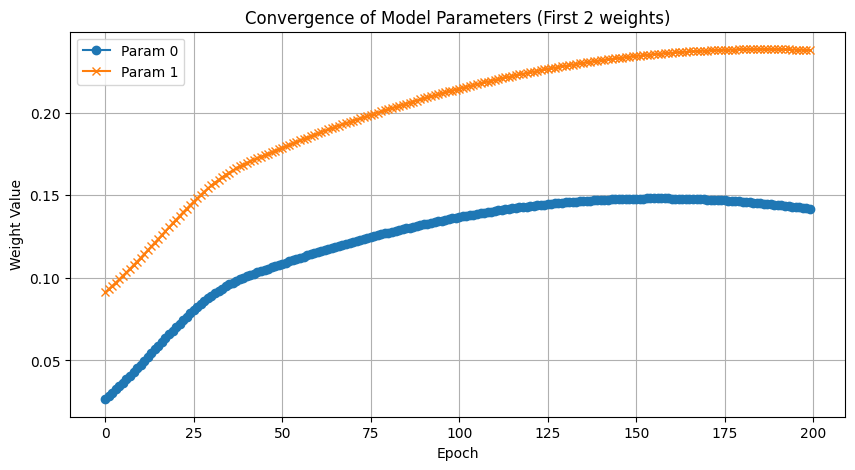


Visualizing Test Sample...


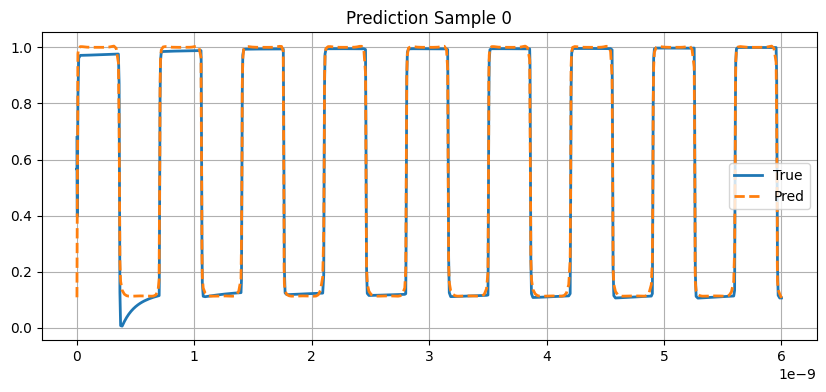

In [25]:
# ================================================================

# ================================================================
# 7)  EVALUATION & PLOTTING
# ================================================================
print("\n=== EVALUATION REPORT ===")

# 1. Metrics
train_loss, train_mae, train_mse = model.evaluate(Xtr, Ytr, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(Xte, Yte, verbose=0)

# 2. Inference Time
t0 = time.perf_counter()
_ = model.predict(Xte[:1], verbose=0)
inf_time = (time.perf_counter() - t0) * 1000 # ms

print(f"{'Metric':<15} | {'Train':<12} | {'Test':<12}")
print("-" * 45)
print(f"{'MSE':<15} | {train_mse:.5f}      | {test_mse:.5f}")
print(f"{'MAE':<15} | {train_mae:.5f}      | {test_mae:.5f}")
print("-" * 45)
print(f"Total Train Time: {train_time:.2f} s")
print(f"Inference Time (1 sample): {inf_time:.2f} ms")

# 3. Convergence Plot (Parameters)
try:
    df_params = pd.read_csv('params.csv')
    plt.figure(figsize=(10, 5))
    # Plot first 2 parameters to see convergence
    plt.plot(df_params['epoch'], df_params['p0'], label='Param 0', marker='o')
    plt.plot(df_params['epoch'], df_params['p1'], label='Param 1', marker='x')
    plt.title('Convergence of Model Parameters (First 2 weights)')
    plt.xlabel('Epoch')
    plt.ylabel('Weight Value')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot parameters: {e}")

# 4. Prediction Plot
def plot_sample(X, Y, T, idx=0):
    pred = model.predict(X[idx:idx+1], verbose=0)[0]
    plt.figure(figsize=(10, 4))
    plt.plot(T[idx], Y[idx], label='True', linewidth=2)
    plt.plot(T[idx], pred, label='Pred', linestyle='--', linewidth=2)
    plt.title(f'Prediction Sample {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nVisualizing Test Sample...")
plot_sample(Xte, Yte, Tte, idx=0)